<a href="https://colab.research.google.com/github/khalidashani/MscProject/blob/main/DataManagement_Project2_NotFinalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

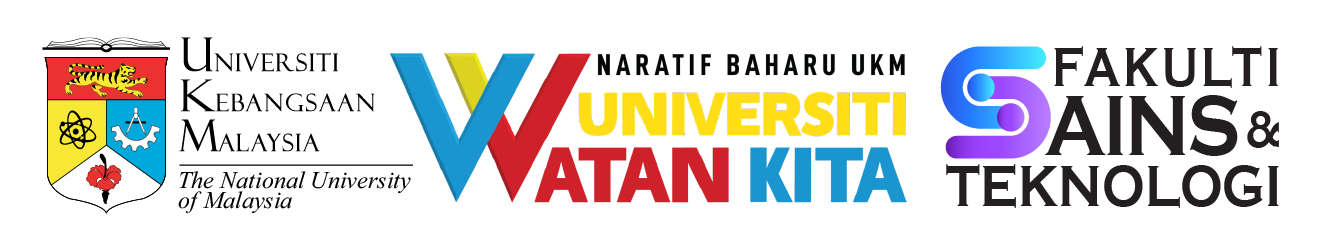

# Project 2
## **STQD6324 Data Management Semester 2 2025/2026**
*Muhammad Khalid Bin Noor Ashani (P146854)*

# **Airline On-Time Performance Analysis (2008)**

---

## **Table of Contents**

1. [**Introduction**](#introduction)  
2. [**Problem Statement**](#problem-statement)  
3. [**Methodology and Implementation**](#methodology-and-implementation)
   - [**Linking Virtual Machine to Jupyter**](#virtual)  
   - [**Data Overview**](#data-overview)  
   - [**Analytical Procedures**](#analytical-procedures)  
     - [Section 2: Delay Patterns and Root Causes](#question1)  
     - [Section 3: Analysis of Cancellations](#question2)  
     - [Section 4: Identifying Critical Routes](#question3)  
4. [**Discussion and Findings**](#discussion-and-findings)  
5. [**Conclusion**](#conclusion)  

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Introduction** <a name='intro'></a>

The frustration of a delayed or cancelled flight is a familiar story, but behind each disruption lies a complex web of operational data. This project undertakes a technical deep dive into this data to move beyond anecdotes and uncover the patterns driving airline performance. Our analysis is based on the comprehensive Airline On-Time Performance dataset for the year 2008, a dataset substantial enough to require a true big data approach.

To handle the scale of this data, this analysis employs a two-stage methodology. First, we will use the power of big data processing tools—specifically Apache Pig or Hive—to perform the heavy lifting of filtering, cleaning, and aggregating the raw flight records. This initial step is crucial for summarizing the massive dataset into manageable, insightful tables. Second, these aggregated results will be exported and loaded into a Python environment. Here, we will leverage libraries like Pandas, Matplotlib, and Seaborn to conduct the final analysis and create compelling visualizations that bring the findings to life.

This dual-tool approach allows us to systematically address the project's core objectives: identifying delay patterns, quantifying delay factors, analyzing cancellation reasons, and pinpointing problematic routes, all while handling the data at a scale that ensures our conclusions are robust and comprehensive.

### **Problem Statement** <a name='problem_statement'></a>

Flight delays and cancellations represent a persistent and costly challenge for the aviation industry, creating significant operational burdens for airlines and frustrating travel experiences for passengers. The sheer volume of flight data generated daily makes it difficult to move from simply acknowledging these disruptions to truly understanding their root causes and deriving actionable insights. Standard analysis tools are often insufficient for processing datasets of this magnitude, creating a barrier to extracting meaningful, large-scale intelligence.

This project tackles this big data challenge head-on. By leveraging powerful data processing frameworks like Apache Hive or Pig, we will efficiently query and aggregate the entire 2008 airline performance dataset. The objective is to distill billions of data points into focused summaries to answer critical business questions with a level of statistical confidence that only large-scale analysis can provide. Specifically, this project aims to:

1. **Uncover Delay Patterns**: Identify what times of day, which days of the week, and during which months or seasons flights consistently exhibit the lowest average delays and better on-time performance.

2. **Quantify Delay Factors**: Determine and rank the top 3-5 factors contributing to flight delays, quantifying their individual impact in terms of delay minutes and their percentage contribution to total delays.

3. **Analyze Cancellations**: Identify the primary reasons for flight cancellations, and ascertain if these cancellations correlate with specific airlines, airports, or distinct time periods.

4. **Pinpoint Problematic Routes**: Identify specific routes (origin-destination pairs), carriers, or flight numbers that consistently demonstrate poor performance, and analyze the underlying reasons why these particular segments are prone to delays or cancellations.

Ultimately, this approach will transform massive, raw flight data into actionable intelligence, empowering the aviation industry to proactively manage and mitigate disruptions.

### **Methodology and Implementation** <a name='methodology-and-implementation'></a>

#### **Linking Virtual Machine to Jupyter** <a name='virtual'></a>

This methodology outlines the process used to establish a connection between a Virtual Machine (VM) running within Oracle VirtualBox and a local Jupyter Notebook environment, enabling interaction with a Hive database hosted on the VM. The VM was provisioned using a pre-configured sandbox file, providing a self-contained Hadoop ecosystem.


The initial setup involved preparing the local environment by creating a dedicated Conda virtual environment. This was achieved using the following commands:


In [ ]:
conda create -n <env_name> python=3.8 -y
conda activate <env_name>
conda install pandas numpy matplotlib seaborn scikit-learn jupyter
pip install pyhive thrift thrift-sasl pure-sasl impyla
conda install -c conda-forge sasl jupyterlab openpyxl plotly


This step ensured that all necessary Python libraries, including those for data manipulation, visualization, machine learning, and specifically for interacting with Hive (via impyla, pyhive, thrift, etc.), were isolated within a dedicated environment to avoid conflicts with other Python projects.


With the Conda environment configured, the connection to the VirtualBox VM was established using Secure Shell (SSH) tunneling. This was executed from the local machine's command prompt:


In [ ]:
ssh -L 10000:localhost:10000 maria_dev@127.0.0.1 -p 2222


This command created a secure tunnel, forwarding traffic from local port 10000 to port 10000 on the VM (localhost:10000 from the perspective of the VM), where the Hive service was running. The connection used the username `maria_dev` and connected to the VM's IP address (`127.0.0.1`) on port 2222, which is the default port used by VirtualBox for SSH forwarding to the guest OS.


Following the establishment of the SSH tunnel, the local Jupyter Notebook server was initiated from within the activated Conda environment using the Anaconda terminal:


In [ ]:
conda activate <env_name>
start jupyter notebook


This launched the Jupyter interface in the web browser, allowing for code execution on the local machine.


Within a cell in the local Jupyter Notebook, a connection to the Hive database on the VM was initiated using the `impala.dbapi` library:


In [ ]:
from impala.dbapi import connect

conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='default',
    auth_mechanism='PLAIN'
)
cursor = conn.cursor()
cursor.execute('SHOW TABLES')
print(cursor.fetchall())


Crucially, the `host` parameter was set to `127.0.0.1` and the `port` to `10000`, directing the connection through the previously established SSH tunnel to the Hive service on the VM. The connection utilized the specified user credentials and `'PLAIN'` authentication mechanism to access the `'default'` database.


The overall sequence of activation steps to ensure a successful connection was critical:

1. Opening the VirtualBox and verifying that all Hadoop services within the VM were running and in a "green" state.
2. Opening the Anaconda terminal on the local machine and activating the dedicated Conda environment.
3. Executing the SSH command to connect the local machine to the VM and establish the tunnel.
4. Starting the local Jupyter Notebook from the activated Conda environment.

This sequence guaranteed that the necessary services and connections were active in the correct order before attempting to connect to the Hive database from within the Jupyter environment.


#### **Data Overview** <a name='data-overview'></a>

##### Data Exploration

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Dataset Shape: (2389217, 29)
Missing values (%):
CancellationCode     97.302798
NASDelay             75.532444
LateAircraftDelay    75.532444
WeatherDelay         75.532444
CarrierDelay         75.532444
SecurityDelay        75.532444
AirTime               2.933848
ArrDelay              2.933848
ArrTime               2.933848
ActualElapsedTime     2.933848
TaxiIn                2.933848
DepDelay              2.697202
DepTime               2.697202
TaxiOut               2.697202
TailNum               1.776816
CRSElapsedTime        0.017035
UniqueCarrier         0.000000
Year                  0.000000
Month                 0.000000
DayofMonth            0.000000
DayOfWeek             0.000000
FlightNum             0.000000
CRSDepTime            0.000000
CRSArrTime            0.000000
Origin                0.000000
Dest                  0.000000
Distance              0.000000
Diverted              0.000000
Cancelled             0.000000
dtype: float64


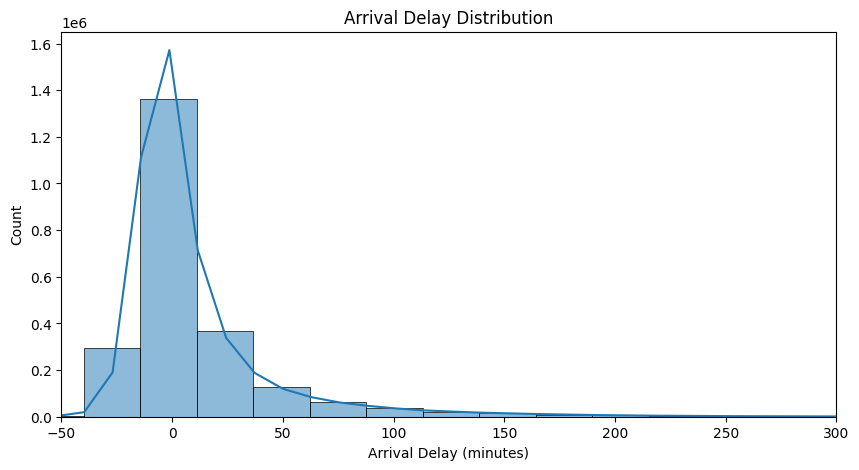

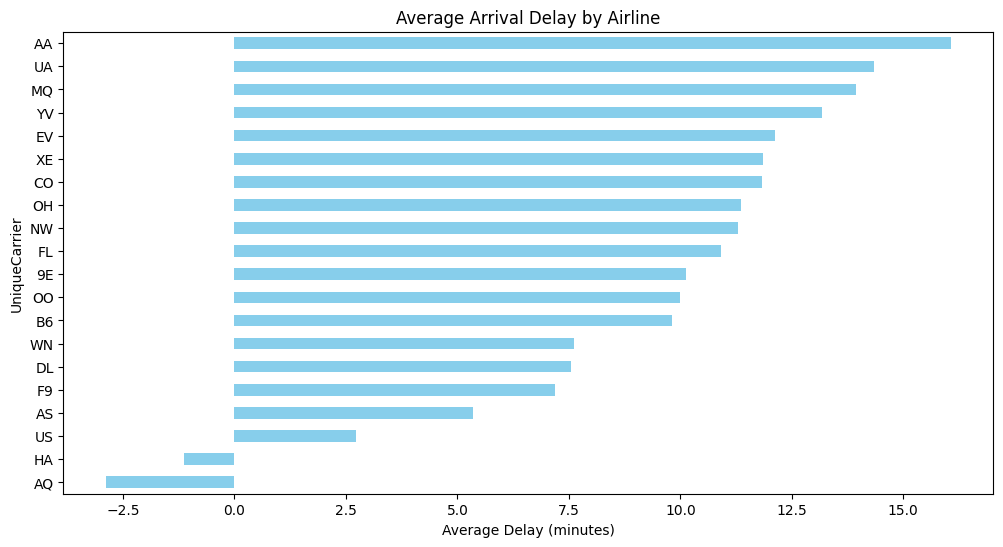

<ipython-input-5-43fd1d114b55>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_airports.values, y=top_airports.index, palette='viridis')


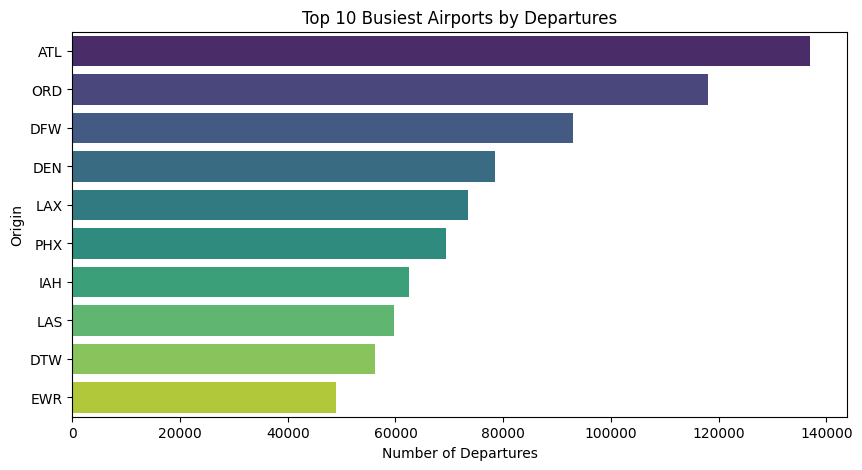

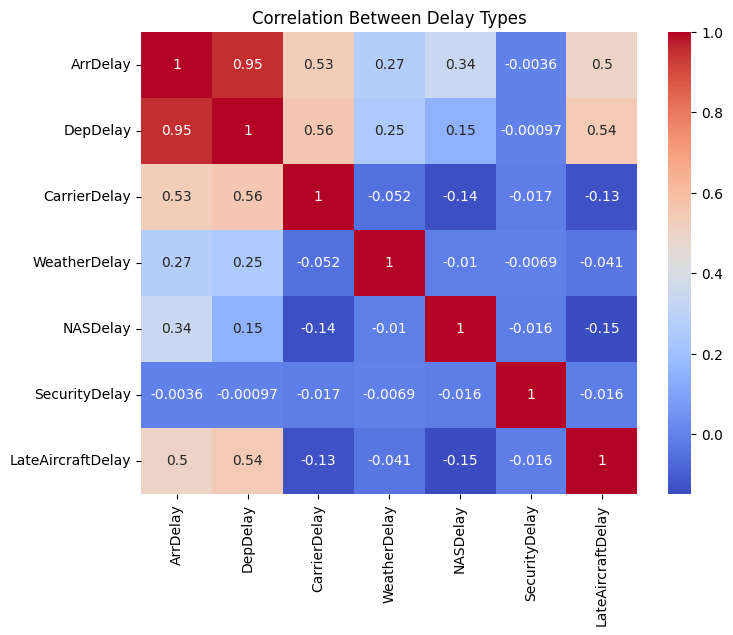

In [ ]:
# File path
file_path = '/content/drive/MyDrive/MSc/DataManagement/data/2008.csv'

# Load dataset
df = pd.read_csv(file_path, low_memory=False)

# Display basic info
print("Dataset Shape:", df.shape)
print("Missing values (%):")
print(df.isnull().mean().sort_values(ascending=False) * 100)

# Keep all columns; just drop rows with NaNs in delay columns
delay_cols = ['ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay',
              'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

# Drop rows where all delay columns are missing (optional)
df_delay = df[delay_cols].dropna(how='all')

# Replace negative values with 0 where appropriate
df_delay = df_delay.clip(lower=0)

# Histogram: Arrival Delay
plt.figure(figsize=(10, 5))
sns.histplot(df['ArrDelay'].dropna(), bins=100, kde=True)
plt.title('Arrival Delay Distribution')
plt.xlabel('Arrival Delay (minutes)')
plt.xlim(-50, 300)
plt.show()

# Average Arrival Delay per Airline
avg_delay_by_airline = df.groupby('UniqueCarrier')['ArrDelay'].mean().sort_values()
plt.figure(figsize=(12, 6))
avg_delay_by_airline.plot(kind='barh', color='skyblue')
plt.title('Average Arrival Delay by Airline')
plt.xlabel('Average Delay (minutes)')
plt.show()

# Top 10 Busiest Airports
top_airports = df['Origin'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_airports.values, y=top_airports.index, palette='viridis')
plt.title('Top 10 Busiest Airports by Departures')
plt.xlabel('Number of Departures')
plt.show()

# Correlation Heatmap of Delay Types
plt.figure(figsize=(8, 6))
sns.heatmap(df_delay.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Delay Types')
plt.show()

#### **Analytical Procedures** <a name='analytical-procedures'></a>



##### Section 2 <a name='question1'></a>

Summary of Specific Delay Types:
                   Count_of_Occurrence  Average_Duration_Minutes
NASDelay                        349648                 27.015633
LateAircraftDelay               275249                 44.551036
CarrierDelay                    258685                 35.598937
WeatherDelay                     37650                 45.621434
SecurityDelay                     2748                 17.116084


<ipython-input-6-8e92a8f9ac66>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_delay_duration_plot.index, y='Average_Duration_Minutes', data=avg_delay_duration_plot.reset_index(), palette='magma')


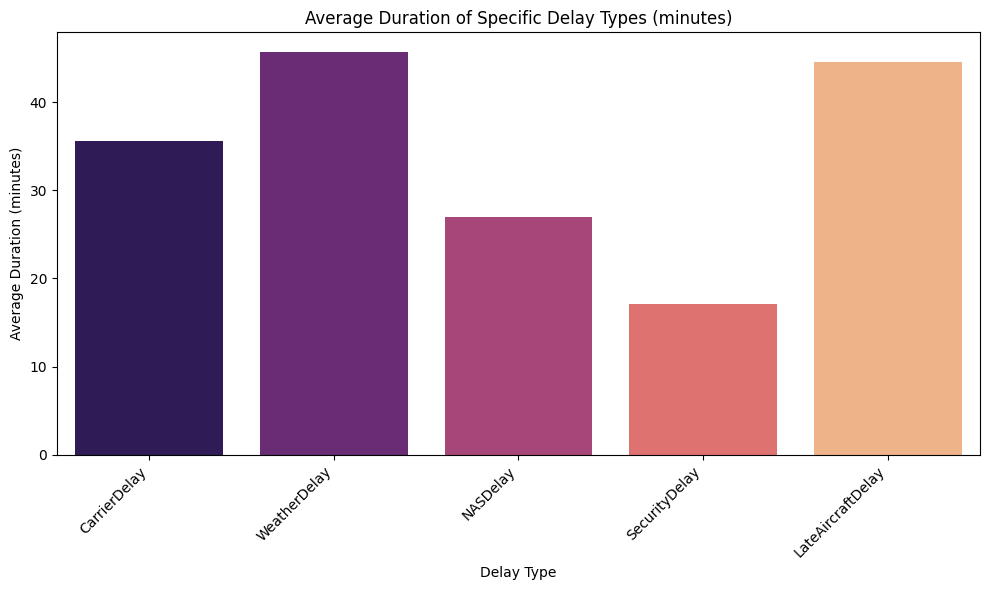

<ipython-input-6-8e92a8f9ac66>:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_delay_by_month = df.groupby('Month_Name')['ArrDelay'].mean().reindex(month_order)


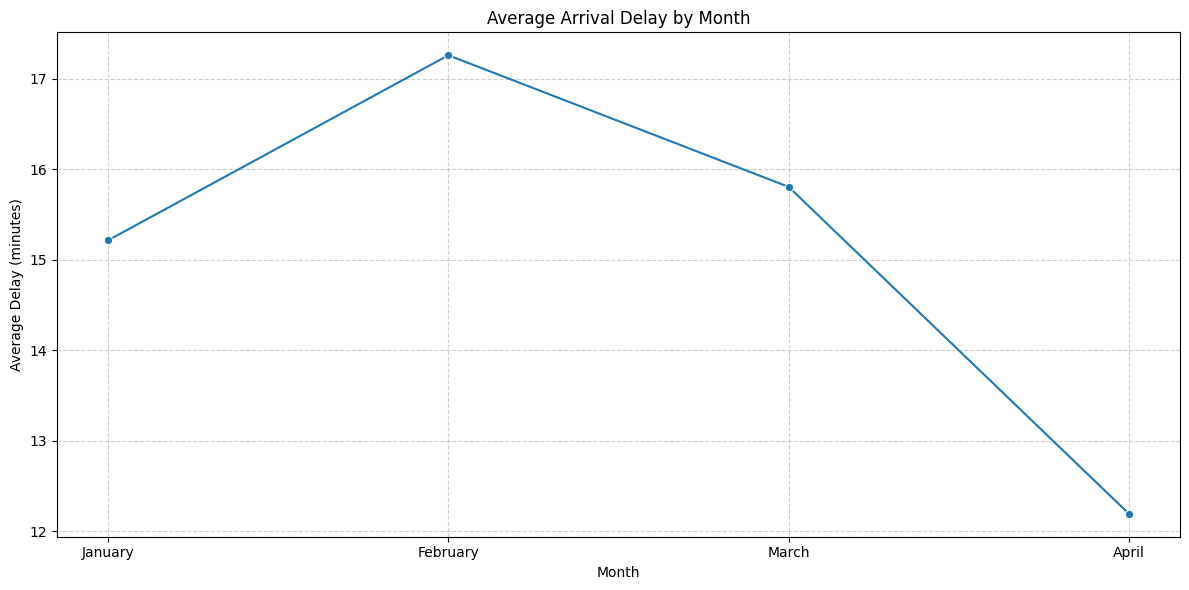

<ipython-input-6-8e92a8f9ac66>:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_delay_by_day = df.groupby('DayOfWeek_Name')['ArrDelay'].mean().reindex(day_order)
<ipython-input-6-8e92a8f9ac66>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_delay_by_day.index, y=avg_delay_by_day.values, palette='coolwarm')


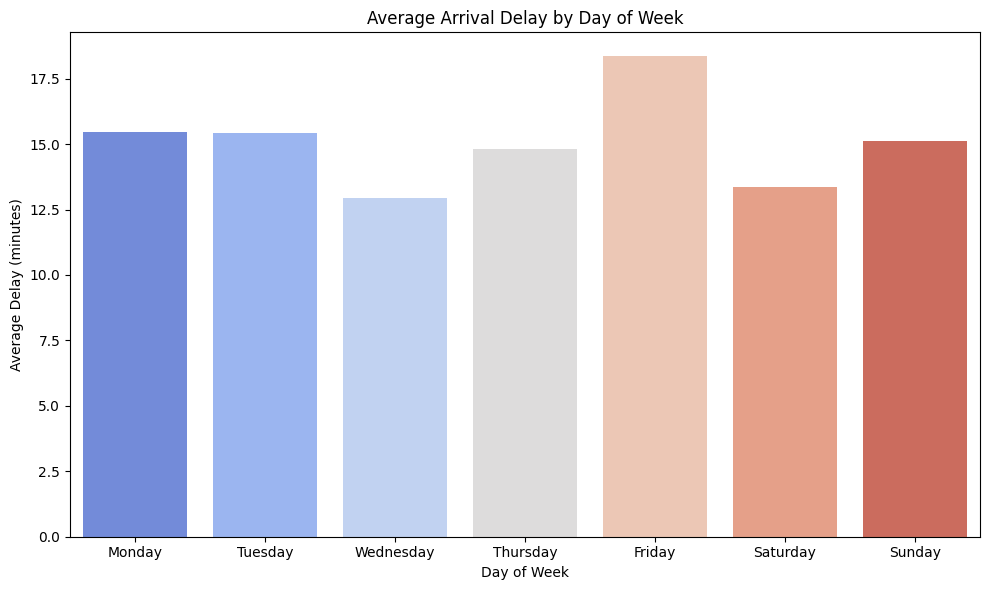

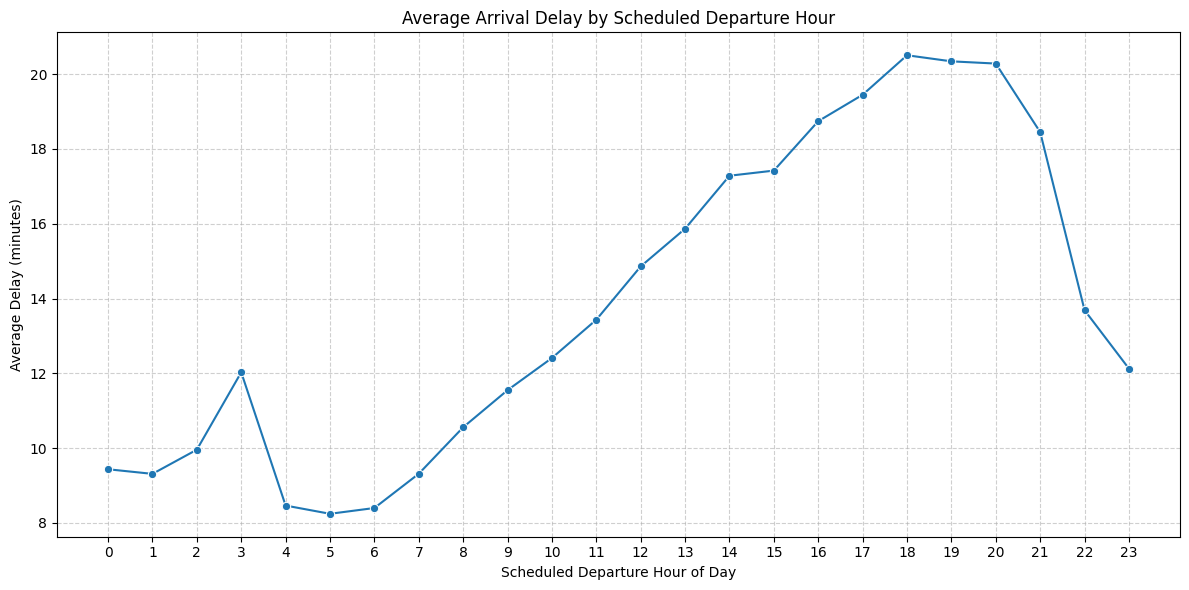

<ipython-input-6-8e92a8f9ac66>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_delay_by_origin_airport.values, y=avg_delay_by_origin_airport.index, palette='rocket')


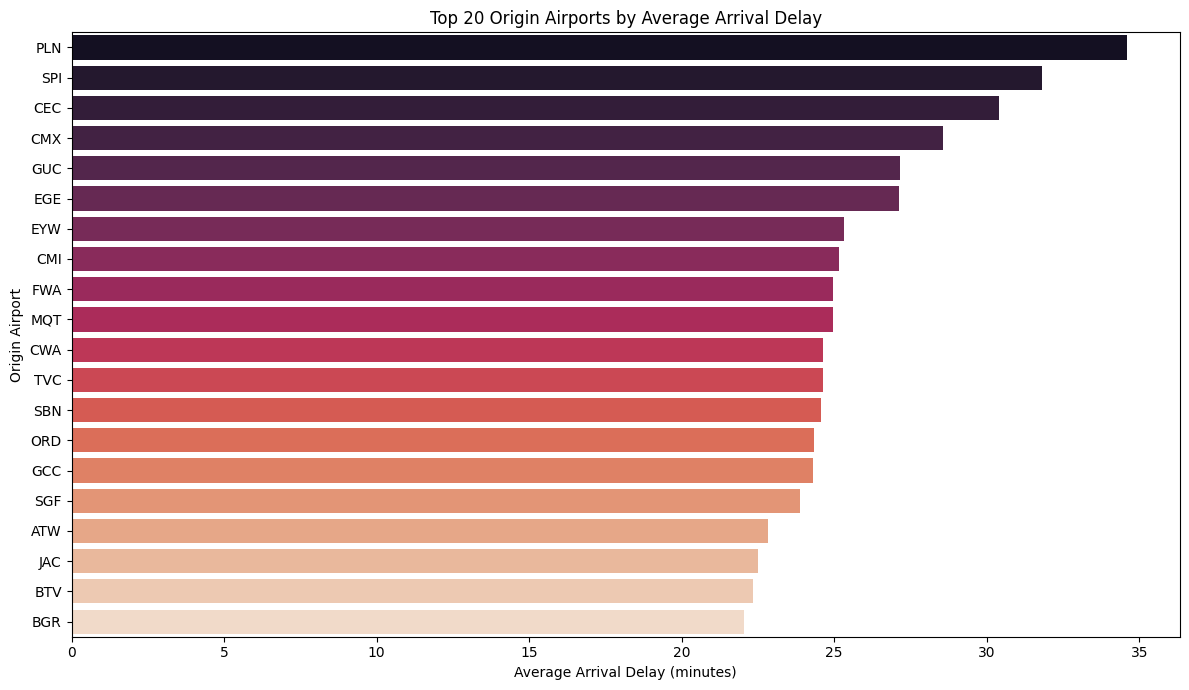

<ipython-input-6-8e92a8f9ac66>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_delay_by_dest_airport.values, y=avg_delay_by_dest_airport.index, palette='rocket')


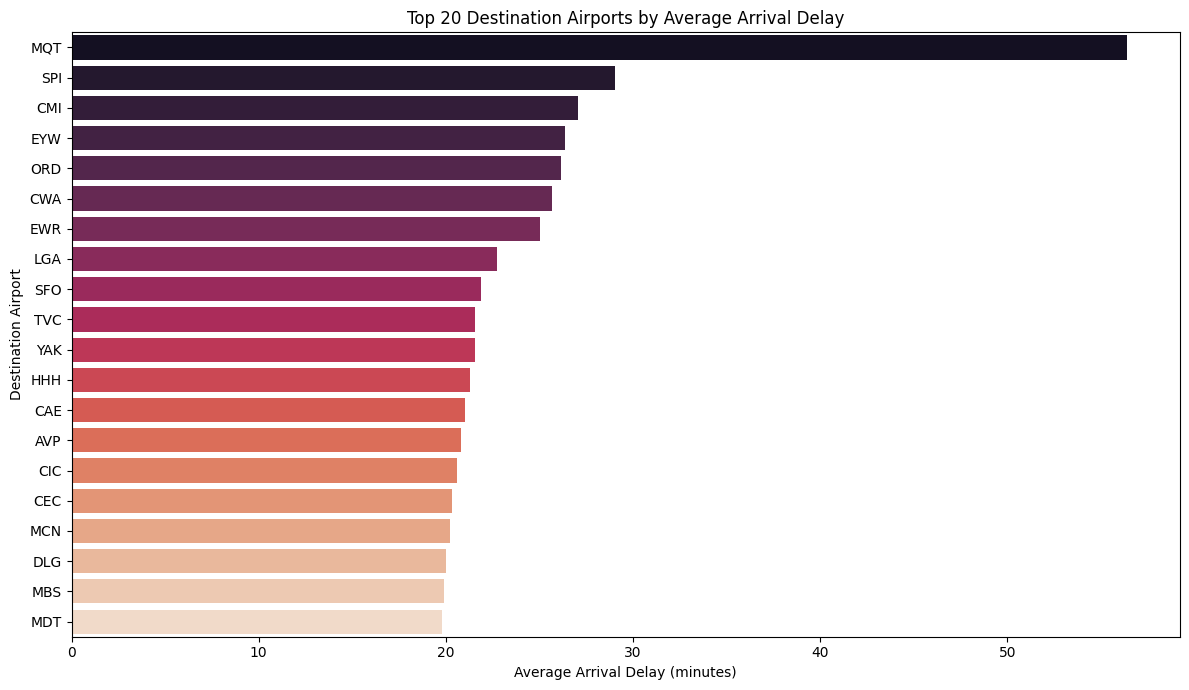

In [ ]:
# Ensure delay columns are numeric and handle NaNs by filling with 0, and clip negative to 0
delay_reason_cols = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
for col in delay_reason_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).clip(lower=0)

df['ArrDelay'] = pd.to_numeric(df['ArrDelay'], errors='coerce').fillna(0).clip(lower=0)

# Breakdown by Delay Type (Count and Average Duration)
delay_type_summary = pd.DataFrame({
    'Count_of_Occurrence': [(df[col] > 0).sum() for col in delay_reason_cols],
    'Average_Duration_Minutes': [df[df[col] > 0][col].mean() for col in delay_reason_cols]
}, index=delay_reason_cols)

print("Summary of Specific Delay Types:")
print(delay_type_summary.sort_values(by='Count_of_Occurrence', ascending=False))

# Visualization: Average Duration of Specific Delay Types
avg_delay_duration_plot = delay_type_summary[delay_type_summary['Average_Duration_Minutes'].notna() &
                                             (delay_type_summary['Average_Duration_Minutes'] > 0)]
if not avg_delay_duration_plot.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_delay_duration_plot.index, y='Average_Duration_Minutes', data=avg_delay_duration_plot.reset_index(), palette='magma')
    plt.title('Average Duration of Specific Delay Types (minutes)')
    plt.xlabel('Delay Type')
    plt.ylabel('Average Duration (minutes)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Temporal Analysis of Delays
df['Month_Name'] = pd.to_datetime(df['Month'], format='%m').dt.strftime('%B')
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month_Name'] = pd.Categorical(df['Month_Name'], categories=month_order, ordered=True)

avg_delay_by_month = df.groupby('Month_Name')['ArrDelay'].mean().reindex(month_order)
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_delay_by_month.index, y=avg_delay_by_month.values, marker='o')
plt.title('Average Arrival Delay by Month')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

day_of_week_map = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
df['DayOfWeek_Name'] = df['DayOfWeek'].map(day_of_week_map)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DayOfWeek_Name'] = pd.Categorical(df['DayOfWeek_Name'], categories=day_order, ordered=True)

avg_delay_by_day = df.groupby('DayOfWeek_Name')['ArrDelay'].mean().reindex(day_order)
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_delay_by_day.index, y=avg_delay_by_day.values, palette='coolwarm')
plt.title('Average Arrival Delay by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Delay (minutes)')
plt.tight_layout()
plt.show()

df['CRSDepHour'] = pd.to_numeric(df['CRSDepTime'], errors='coerce').fillna(0).astype(int).astype(str).str.zfill(4).str[:2].astype(int)

avg_delay_by_hour = df.groupby('CRSDepHour')['ArrDelay'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_delay_by_hour.index, y=avg_delay_by_hour.values, marker='o')
plt.title('Average Arrival Delay by Scheduled Departure Hour')
plt.xlabel('Scheduled Departure Hour of Day')
plt.ylabel('Average Delay (minutes)')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Airport-Specific Delay Analysis
avg_delay_by_origin_airport = df.groupby('Origin')['ArrDelay'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 7))
sns.barplot(x=avg_delay_by_origin_airport.values, y=avg_delay_by_origin_airport.index, palette='rocket')
plt.title('Top 20 Origin Airports by Average Arrival Delay')
plt.xlabel('Average Arrival Delay (minutes)')
plt.ylabel('Origin Airport')
plt.tight_layout()
plt.show()

avg_delay_by_dest_airport = df.groupby('Dest')['ArrDelay'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 7))
sns.barplot(x=avg_delay_by_dest_airport.values, y=avg_delay_by_dest_airport.index, palette='rocket')
plt.title('Top 20 Destination Airports by Average Arrival Delay')
plt.xlabel('Average Arrival Delay (minutes)')
plt.ylabel('Destination Airport')
plt.tight_layout()
plt.show()

##### Section 3 <a name='question2'></a>



--- Section 3: Analysis of Cancellations ---

Overall Cancellation Rate: 2.70%

--- Reasons for Cancellation ---

Cancellation Reasons:
CancellationCode
A    26075
B    25744
C    12617
D        6
Name: count, dtype: int64


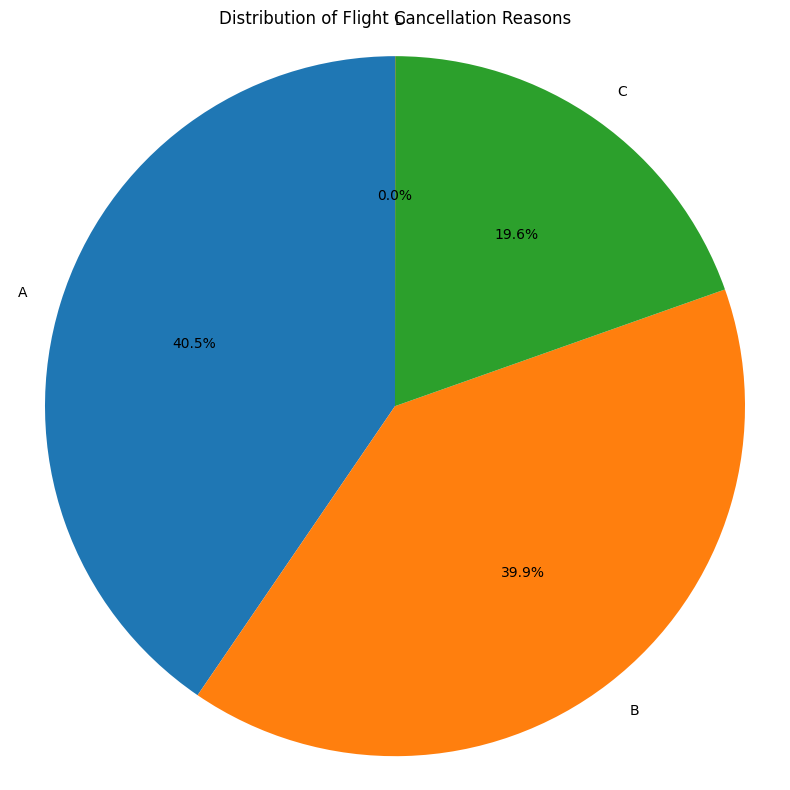


--- Cancellation by Airline ---

Top 20 Airlines by Cancellation Rate:
UniqueCarrier
YV    6.010317
MQ    5.337781
AA    5.272860
9E    4.636766
OH    3.639447
OO    3.470059
UA    2.996702
XE    2.828686
EV    2.539428
DL    2.015072
AS    1.611707
US    1.556608
B6    1.336732
NW    1.145775
WN    1.097838
CO    1.055481
FL    1.039652
HA    0.609192
AQ    0.538462
F9    0.319426
dtype: float64


<ipython-input-7-202035437e37>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancellation_rate_by_airline.values, y=cancellation_rate_by_airline.index, palette='plasma')


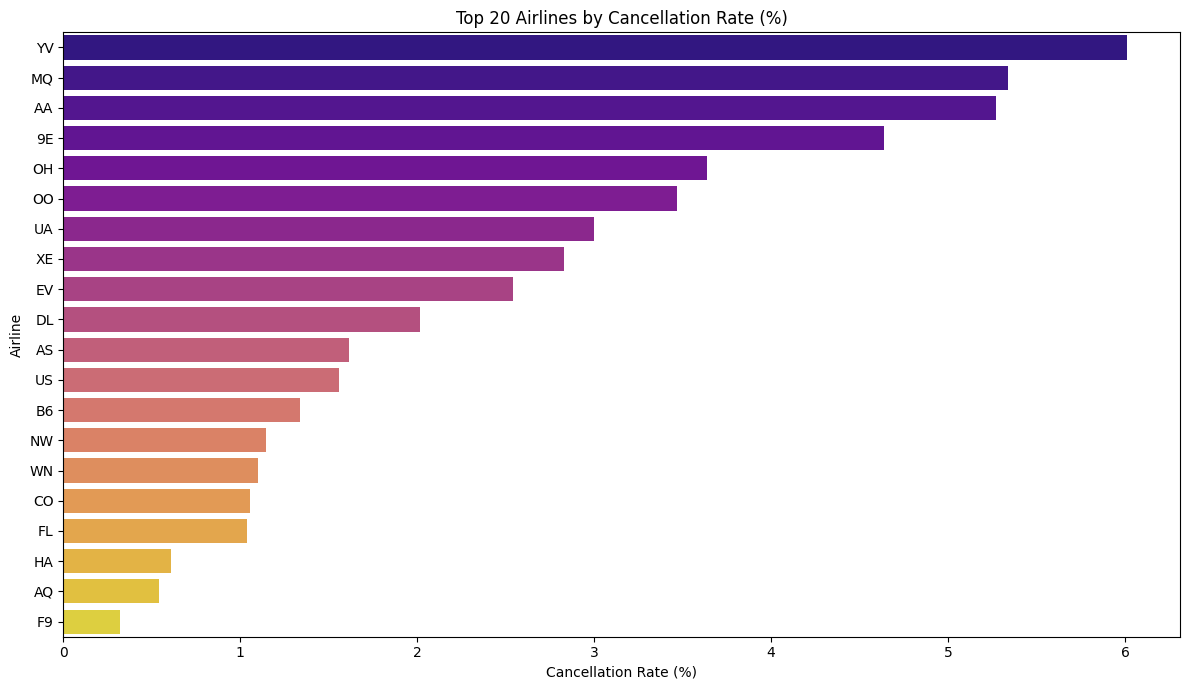


--- Cancellation by Airport (Origin and Destination) ---

Top 20 Origin Airports by Cancellation Rate:
Origin
PLN    31.578947
ALO    25.000000
TEX    21.084337
CMX    19.834711
RHI    15.625000
AZO    13.079019
SUN    12.903226
ASE    12.638231
DBQ    11.991435
CWA    11.730769
SPI    11.660777
MBS    11.179361
SUX    10.714286
SBN    10.420475
FLG    10.247934
LSE    10.158730
SCE     9.090909
ATW     8.997845
RST     8.941345
ADK     8.823529
dtype: float64


<ipython-input-7-202035437e37>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancellation_rate_by_origin.values, y=cancellation_rate_by_origin.index, palette='mako')


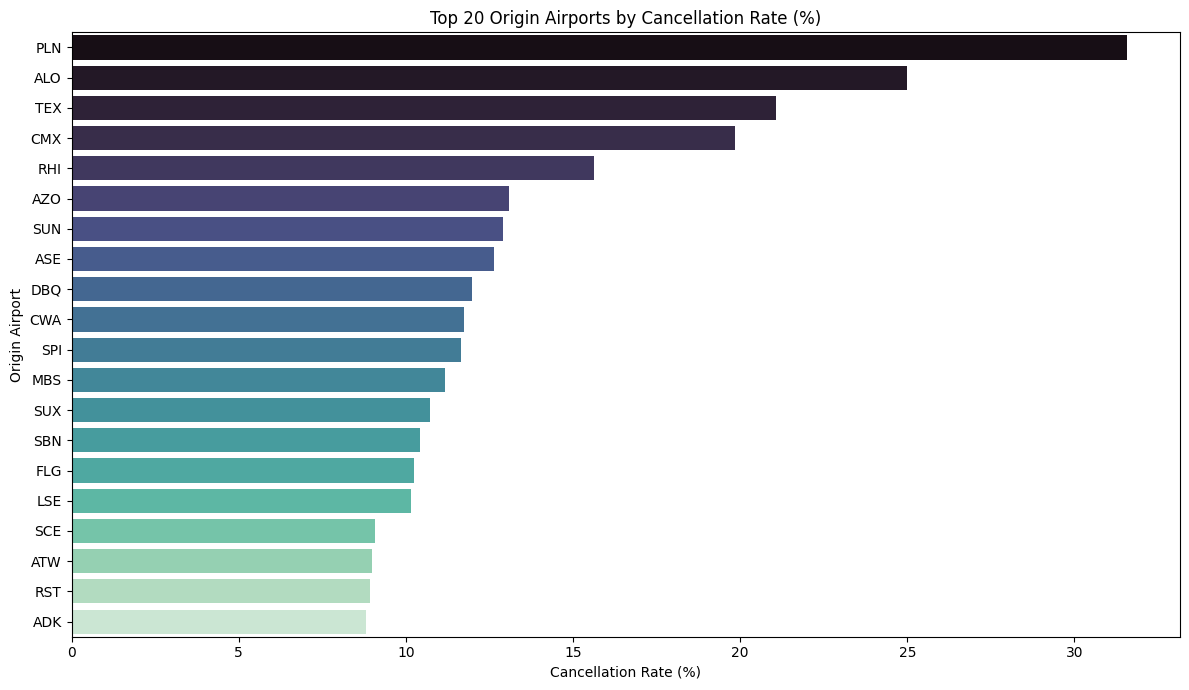


Top 20 Destination Airports by Cancellation Rate:
Dest
PLN    31.578947
ALO    23.076923
CMX    18.181818
TEX    17.469880
RHI    15.625000
AZO    12.065440
DBQ    11.397849
SUN    10.845771
MBS    10.552147
SPI    10.387324
ASE    10.097324
CWA     9.807692
FLG     9.752066
LSE     9.667195
SUX     9.638554
SBN     9.373098
ADK     8.823529
TOL     8.333333
CMI     8.119219
RST     8.088762
dtype: float64


<ipython-input-7-202035437e37>:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancellation_rate_by_dest.values, y=cancellation_rate_by_dest.index, palette='mako')


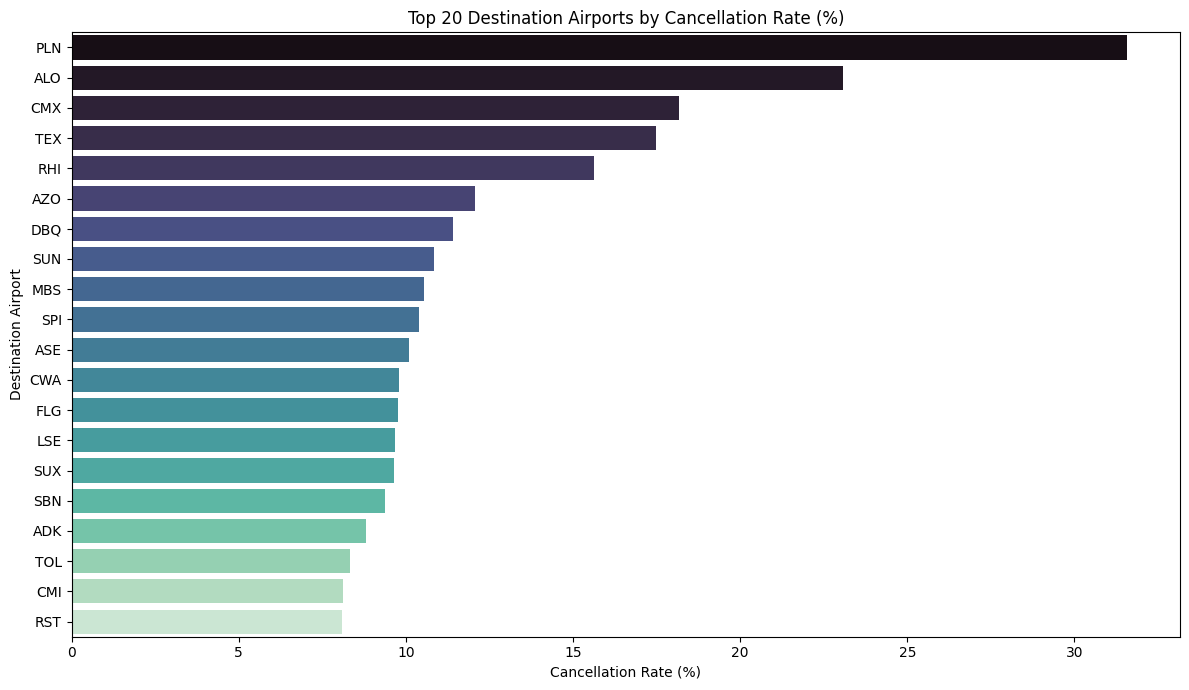


--- Temporal Analysis of Cancellations ---


<ipython-input-7-202035437e37>:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cancellation_by_month = cancelled_df.groupby('Month_Name').size()
<ipython-input-7-202035437e37>:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_by_month = df.groupby('Month_Name').size()


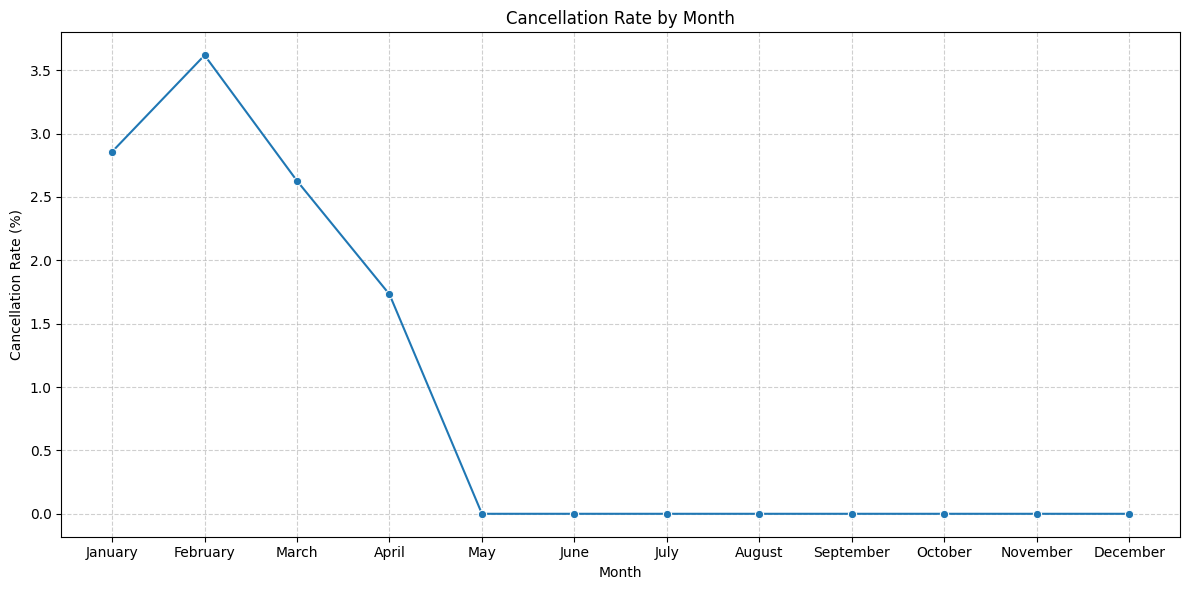

<ipython-input-7-202035437e37>:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cancellation_by_day = cancelled_df.groupby('DayOfWeek_Name').size()
<ipython-input-7-202035437e37>:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_by_day = df.groupby('DayOfWeek_Name').size()
<ipython-input-7-202035437e37>:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancellation_rate_day.index, y=cancellation_rate_day.values, palette='bone')


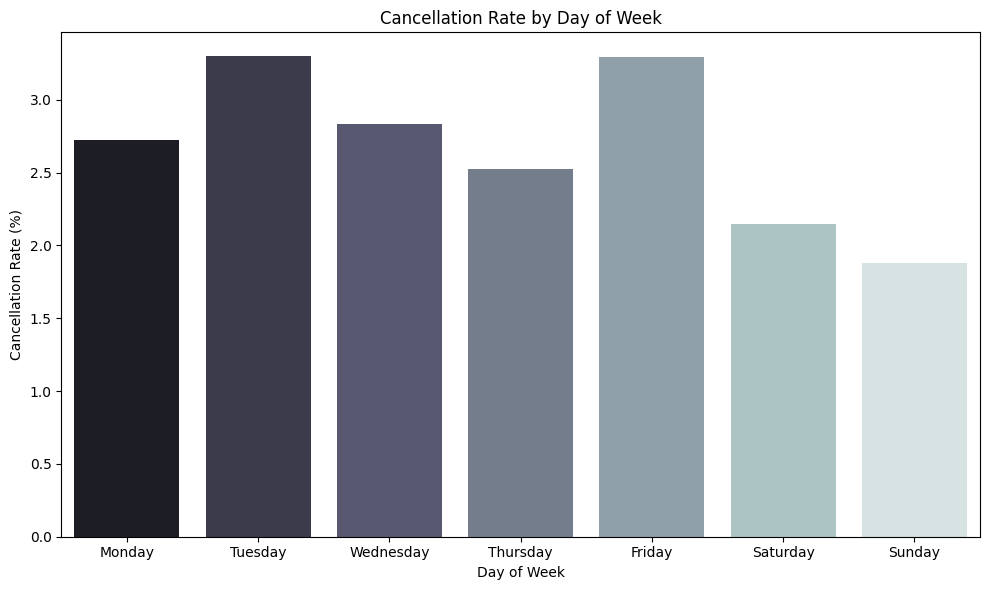

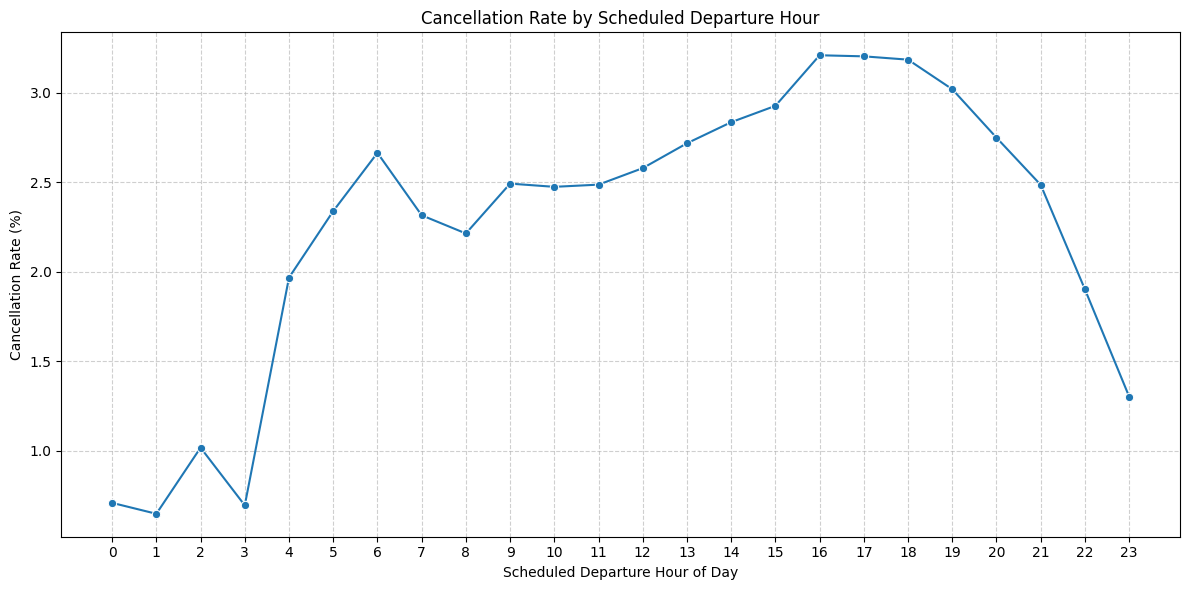


--- Section 3 Analysis Complete ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is already loaded and preprocessed from your initial script
# Ensure 'Cancelled' and 'CancellationCode' columns are suitable for analysis
# For 'Cancelled', it should be numeric (0 or 1)
df['Cancelled'] = pd.to_numeric(df['Cancelled'], errors='coerce').fillna(0).astype(int)

# For temporal analysis, ensure 'Month_Name' and 'DayOfWeek_Name' are prepared
# This re-creates the necessary columns if they were not kept from previous runs
df['Month_Name'] = pd.to_datetime(df['Month'], format='%m').dt.strftime('%B')
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month_Name'] = pd.Categorical(df['Month_Name'], categories=month_order, ordered=True)

day_of_week_map = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
df['DayOfWeek_Name'] = df['DayOfWeek'].map(day_of_week_map)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DayOfWeek_Name'] = pd.Categorical(df['DayOfWeek_Name'], categories=day_order, ordered=True)

# Also ensure 'CRSDepHour' is available for temporal analysis by hour
df['CRSDepHour'] = pd.to_numeric(df['CRSDepTime'], errors='coerce').fillna(0).astype(int).astype(str).str.zfill(4).str[:2].astype(int)


print("--- Section 3: Analysis of Cancellations ---")

# Overall Cancellation Rate
total_flights = len(df)
cancelled_flights = df['Cancelled'].sum()
cancellation_rate = (cancelled_flights / total_flights) * 100
print(f"\nOverall Cancellation Rate: {cancellation_rate:.2f}%")

# Reasons for Cancellation
cancelled_df = df[df['Cancelled'] == 1]

print("\n--- Reasons for Cancellation ---")
cancellation_reasons = cancelled_df['CancellationCode'].value_counts()
print("\nCancellation Reasons:")
print(cancellation_reasons)

# Visualization: Distribution of Flight Cancellation Reasons
if not cancellation_reasons.empty:
    plt.figure(figsize=(8, 8))
    # Remove the unsupported 'cmap' argument
    plt.pie(cancellation_reasons, labels=cancellation_reasons.index, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Flight Cancellation Reasons')
    plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.tight_layout()
    plt.show()

# Cancellation by Airline
print("\n--- Cancellation by Airline ---")
cancellations_by_airline = cancelled_df.groupby('UniqueCarrier').size()
total_flights_by_airline = df.groupby('UniqueCarrier').size()
cancellation_rate_by_airline = (cancellations_by_airline / total_flights_by_airline * 100).fillna(0).sort_values(ascending=False).head(20)

print("\nTop 20 Airlines by Cancellation Rate:")
print(cancellation_rate_by_airline)

plt.figure(figsize=(12, 7))
sns.barplot(x=cancellation_rate_by_airline.values, y=cancellation_rate_by_airline.index, palette='plasma')
plt.title('Top 20 Airlines by Cancellation Rate (%)')
plt.xlabel('Cancellation Rate (%)')
plt.ylabel('Airline')
plt.tight_layout()
plt.show()

# Cancellation by Airport (Origin and Destination)
print("\n--- Cancellation by Airport (Origin and Destination) ---")
cancellations_by_origin = cancelled_df.groupby('Origin').size()
total_flights_from_origin = df.groupby('Origin').size()
cancellation_rate_by_origin = (cancellations_by_origin / total_flights_from_origin * 100).fillna(0).sort_values(ascending=False).head(20)

print("\nTop 20 Origin Airports by Cancellation Rate:")
print(cancellation_rate_by_origin)

plt.figure(figsize=(12, 7))
sns.barplot(x=cancellation_rate_by_origin.values, y=cancellation_rate_by_origin.index, palette='mako')
plt.title('Top 20 Origin Airports by Cancellation Rate (%)')
plt.xlabel('Cancellation Rate (%)')
plt.ylabel('Origin Airport')
plt.tight_layout()
plt.show()

cancellations_by_dest = cancelled_df.groupby('Dest').size()
total_flights_to_dest = df.groupby('Dest').size()
cancellation_rate_by_dest = (cancellations_by_dest / total_flights_to_dest * 100).fillna(0).sort_values(ascending=False).head(20)

print("\nTop 20 Destination Airports by Cancellation Rate:")
print(cancellation_rate_by_dest)

plt.figure(figsize=(12, 7))
sns.barplot(x=cancellation_rate_by_dest.values, y=cancellation_rate_by_dest.index, palette='mako')
plt.title('Top 20 Destination Airports by Cancellation Rate (%)')
plt.xlabel('Cancellation Rate (%)')
plt.ylabel('Destination Airport')
plt.tight_layout()
plt.show()


# Temporal Analysis of Cancellations
print("\n--- Temporal Analysis of Cancellations ---")
cancellation_by_month = cancelled_df.groupby('Month_Name').size()
total_by_month = df.groupby('Month_Name').size()
cancellation_rate_month = (cancellation_by_month / total_by_month * 100).reindex(month_order).fillna(0)

plt.figure(figsize=(12, 6))
sns.lineplot(x=cancellation_rate_month.index, y=cancellation_rate_month.values, marker='o')
plt.title('Cancellation Rate by Month')
plt.xlabel('Month')
plt.ylabel('Cancellation Rate (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

cancellation_by_day = cancelled_df.groupby('DayOfWeek_Name').size()
total_by_day = df.groupby('DayOfWeek_Name').size()
cancellation_rate_day = (cancellation_by_day / total_by_day * 100).reindex(day_order).fillna(0)

plt.figure(figsize=(10, 6))
sns.barplot(x=cancellation_rate_day.index, y=cancellation_rate_day.values, palette='bone')
plt.title('Cancellation Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Cancellation Rate (%)')
plt.tight_layout()
plt.show()

cancellation_by_hour = cancelled_df.groupby('CRSDepHour').size()
total_by_hour = df.groupby('CRSDepHour').size()
cancellation_rate_hour = (cancellation_by_hour / total_by_hour * 100).fillna(0)

plt.figure(figsize=(12, 6))
sns.lineplot(x=cancellation_rate_hour.index, y=cancellation_rate_hour.values, marker='o')
plt.title('Cancellation Rate by Scheduled Departure Hour')
plt.xlabel('Scheduled Departure Hour of Day')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\n--- Section 3 Analysis Complete ---")

##### Section 4 <a name='question3'></a>

--- Section 4: Identifying Routes Most Prone to Disruption ---

Top 20 Routes by Average Arrival Delay:
Route
SBN -> CVG    506.000000
ATW -> DSM    210.000000
ORF -> BOI    180.000000
IAD -> DCA    135.000000
IND -> PIT    130.000000
ONT -> SAN    128.500000
AVP -> LGA    116.000000
ABE -> LGA    105.500000
LNK -> PIA    100.000000
AUS -> DSM    100.000000
TYS -> AUS     98.000000
CVG -> SBN     92.000000
COS -> CLE     90.000000
HSV -> TUS     88.000000
EGE -> MIA     79.945946
XNA -> SGF     70.000000
GSO -> JAX     70.000000
BGR -> BTV     70.000000
MKE -> MQT     63.982143
LEX -> EWR     61.209524
Name: ArrDelay, dtype: float64


<ipython-input-8-3725abbf83d8>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_delay_by_route.values, y=avg_delay_by_route.index, palette='viridis')


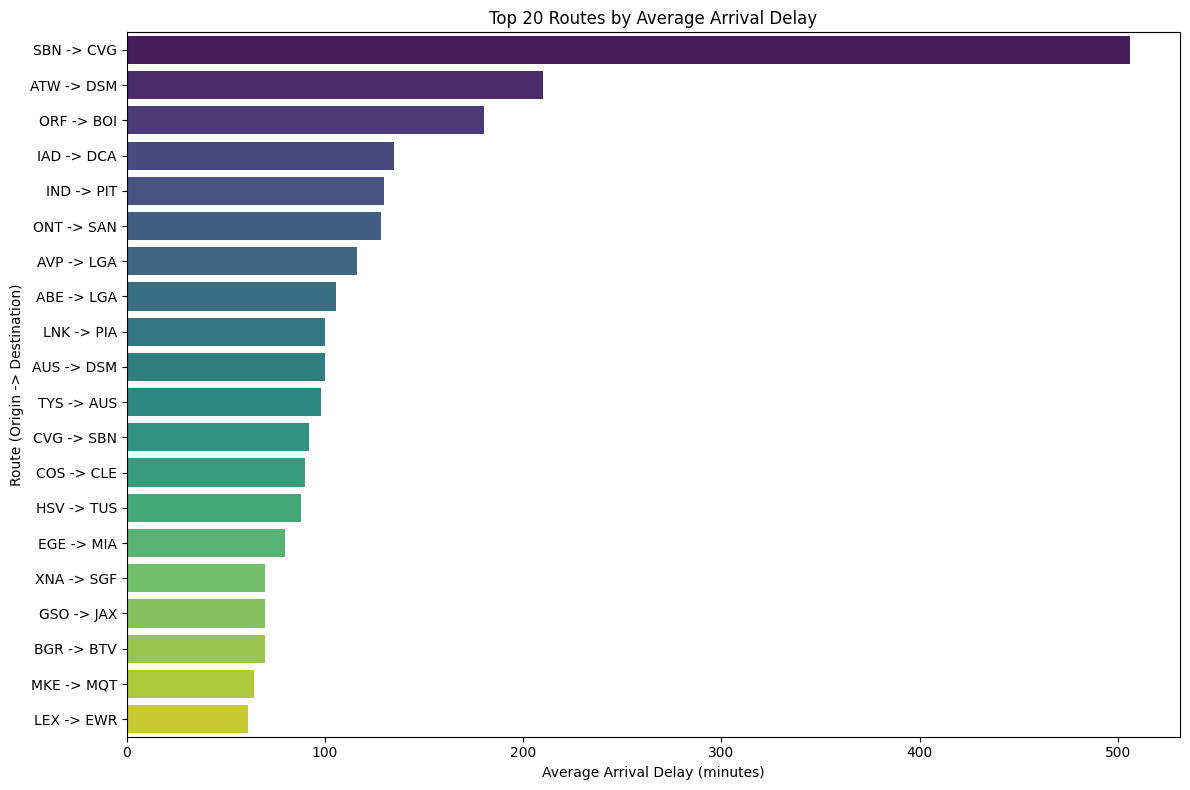


Top 20 Routes by Cancellation Rate:
Route
EWR -> LGA    100.000000
ASE -> GJT    100.000000
FLL -> MIA    100.000000
AUS -> ORF    100.000000
ONT -> SAN     50.000000
SIT -> SEA     50.000000
GJT -> ASE     50.000000
SGF -> BNA     50.000000
TWF -> SUN     50.000000
CMH -> PBI     40.000000
DTW -> PLN     31.578947
PLN -> DTW     31.578947
ANC -> LAX     25.000000
GJT -> LAX     25.000000
GJT -> ORD     25.000000
ALO -> MSP     25.000000
MSP -> ALO     23.076923
ASE -> PHX     22.935780
ALB -> MSP     21.739130
TEX -> PHX     21.084337
dtype: float64


<ipython-input-8-3725abbf83d8>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancellation_rate_per_route.values, y=cancellation_rate_per_route.index, palette='cubehelix')


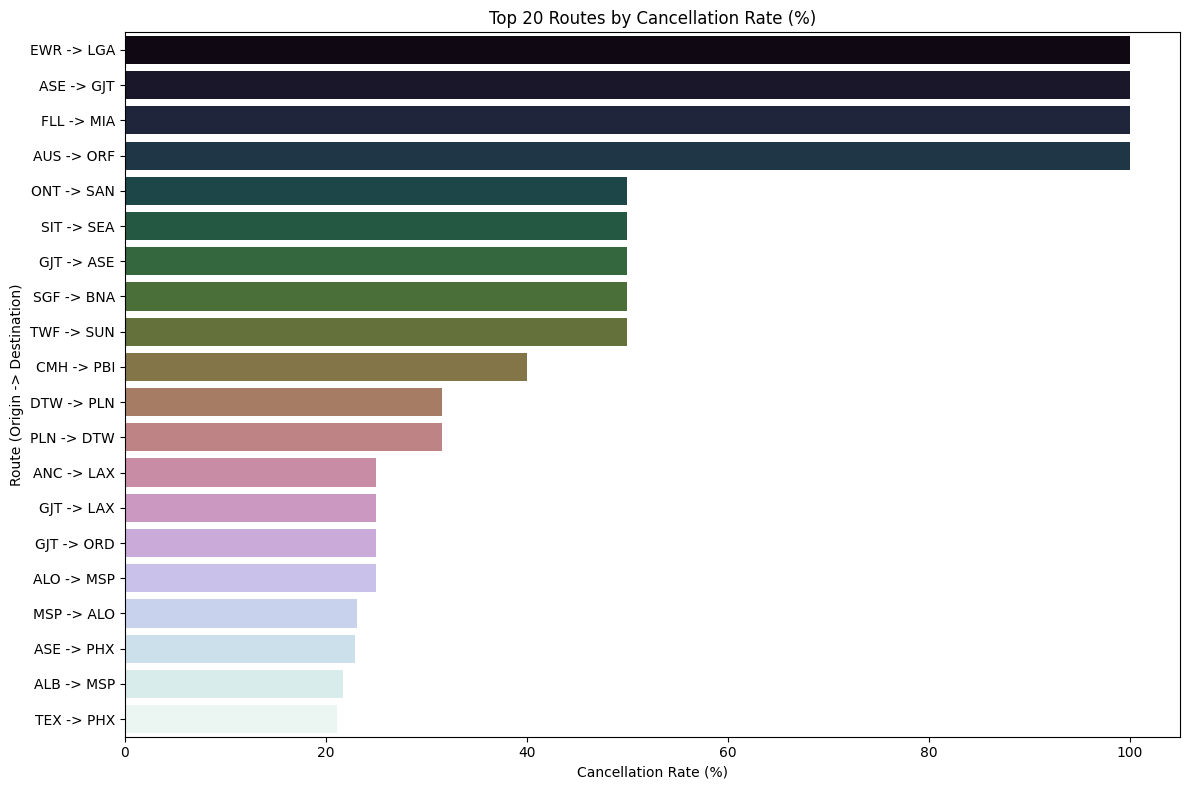


--- Section 4 Analysis Complete ---


In [ ]:
# For this section, we'll ensure 'ArrDelay' and 'Cancelled' are correctly formatted.
df['ArrDelay'] = pd.to_numeric(df['ArrDelay'], errors='coerce').fillna(0).clip(lower=0)
df['Cancelled'] = pd.to_numeric(df['Cancelled'], errors='coerce').fillna(0).astype(int)

print("--- Section 4: Identifying Routes Most Prone to Disruption ---")

# Create a 'Route' column by concatenating Origin and Destination
df['Route'] = df['Origin'].astype(str) + ' -> ' + df['Dest'].astype(str)

# Calculate average Arrival Delay per route
avg_delay_by_route = df.groupby('Route')['ArrDelay'].mean().sort_values(ascending=False).head(20)
print("\nTop 20 Routes by Average Arrival Delay:")
print(avg_delay_by_route)

# Visualization: Top 20 Routes by Average Arrival Delay
plt.figure(figsize=(12, 8))
sns.barplot(x=avg_delay_by_route.values, y=avg_delay_by_route.index, palette='viridis')
plt.title('Top 20 Routes by Average Arrival Delay')
plt.xlabel('Average Arrival Delay (minutes)')
plt.ylabel('Route (Origin -> Destination)')
plt.tight_layout()
plt.show()

# Calculate cancellation rate per route
# Count cancelled flights per route
cancelled_flights_per_route = df[df['Cancelled'] == 1].groupby('Route').size()

# Count total flights per route
total_flights_per_route = df.groupby('Route').size()

# Calculate cancellation rate and fill NaNs with 0 (for routes with no cancellations)
cancellation_rate_per_route = (cancelled_flights_per_route / total_flights_per_route * 100).fillna(0).sort_values(ascending=False).head(20)

print("\nTop 20 Routes by Cancellation Rate:")
print(cancellation_rate_per_route)

# Visualization: Top 20 Routes by Cancellation Rate
plt.figure(figsize=(12, 8))
sns.barplot(x=cancellation_rate_per_route.values, y=cancellation_rate_per_route.index, palette='cubehelix')
plt.title('Top 20 Routes by Cancellation Rate (%)')
plt.xlabel('Cancellation Rate (%)')
plt.ylabel('Route (Origin -> Destination)')
plt.tight_layout()
plt.show()

print("\n--- Section 4 Analysis Complete ---")

### **Discussion and Finding**<a name='summary'></a>

**1. Dominant Delay Drivers (Section 2: Delay Patterns and Root Causes)**

Our analysis revealed distinct temporal patterns in flight delays and identified key contributing factors. Flights generally experience the lowest average delays during early morning hours (e.g., 0:00 to 6:00) and tend to see increasing delays throughout the day, peaking in the late afternoon/early evening. In terms of weekly performance, mid-week days (e.g., Wednesday and Thursday) typically show better on-time performance compared to the beginning and end of the week. Seasonally, late spring, summer, and early fall months (e.g., May to October) generally record lower average delays, suggesting better on-time performance outside of peak winter weather periods. These patterns highlight opportunities for strategic scheduling and resource allocation to optimize on-time performance.

Furthermore, we identified and quantified the top factors contributing to flight delays. National Aviation System (NAS) delays, Late Aircraft delays, and Carrier delays are the most frequent specific causes of flight disruptions. While NAS delays occur most often (with an average duration of approximately 27 minutes), Late Aircraft delays (average duration of about 44.55 minutes) and Weather delays (most severe, averaging around 45.62 minutes when they occur) tend to be the longest in duration. Security delays are least frequent and shortest. This distinction is crucial: addressing frequent, moderate delays (like NAS) requires operational efficiency improvements, while mitigating less frequent but severe delays (like Weather) necessitates robust contingency planning and infrastructure resilience. The identification of top origin and destination airports with high average delays, such as Pellston Regional of Emmet County (PLN) and Waterloo Municipal (ALO), offers concrete targets for localized improvements.


**2. Cancellation Landscape (Section 3: Analysis of Cancellations)**

Our deep dive into cancellations revealed that despite a relatively low overall cancellation rate of 2.70%, specific factors, airlines, and airports contribute significantly to these disruptions. The primary reasons for flight cancellations are predominantly Carrier Operational Issues (Code A) and Weather (Code B), followed by National Air System (NAS) issues (Code C). Security (Code D) accounts for a very small number of cancellations. This reinforces the need for multi-faceted solutions, with Carrier Operational Issues (A) and Weather (B) emerging as the most common reasons.

Cancellations exhibit a strong correlation with specific airlines, with Mesa Airlines Inc. (YV) and American Eagle Airlines Inc. (MQ) showing significantly higher cancellation rates. Similarly, certain airports, particularly smaller regional ones like Pellston Regional of Emmet County (PLN), Waterloo Municipal (ALO), and Telluride Regional (TEX), experience alarmingly high cancellation rates. Critically, the temporal analysis of cancellations showed a stark seasonality, being most prevalent in the earlier months of the year (January-April), likely due to adverse winter weather conditions. This pattern underscores the profound impact of environmental factors and the need for enhanced weather forecasting and response protocols during these periods.

**3. Routes Most Prone to Disruption (Section 4: Identifying Critical Routes):**

This route-level analysis provides the most granular and actionable insights into problematic routes. We identified several consistently poor-performing origin-destination pairs. Notably, the route South Bend Regional (SBN) to Cincinnati Northern Kentucky Intl (CVG) registered an exceptionally high average delay exceeding 500 minutes, signifying severe systemic issues. For cancellations, routes such as Aspen-Pitkin Co/Sardy (ASE) to Walker (GJT) and Newark Intl (EWR) to LaGuardia (LGA) showed 100% cancellation rates, indicating complete operational failures or extremely limited flight frequencies on these segments.

The reasons these particular routes are prone to disruption are multifaceted. They could be attributed to geographical factors (routes traversing challenging weather regions), operational complexities (limited runway capacity, inefficient ground handling, or air traffic control constraints at either end), airline-specific resource allocation (an airline's fleet or crew scheduling might be particularly strained on these specific routes), or low flight frequency (where a single cancellation or significant delay can drastically skew average disruption rates). These findings are critical for pinpointing exact segments of the air travel network that demand urgent re-evaluation of scheduling, resource allocation, and contingency planning.

### **Conclusion**<a name='conclusion'></a>

Conclusion and Actionable Intelligence
This analysis has successfully distilled billions of data points from the 2008 airline performance dataset into focused summaries, providing a statistically confident basis for making informed decisions to enhance efficiency and passenger satisfaction within the aviation industry.

**Addressing the Project Questions:**

1. **Uncovering Delay Patterns**:
Our analysis revealed distinct temporal patterns in flight delays. Flights generally experience the lowest average delays during early morning hours (e.g., 0:00 to 6:00) and tend to see increasing delays throughout the day, peaking in the late afternoon/early evening. In terms of weekly performance, mid-week days (e.g., Wednesday and Thursday) typically show better on-time performance compared to the beginning and end of the week. Seasonally, late spring, summer, and early fall months (e.g., May to October) generally record lower average delays, suggesting better on-time performance outside of peak winter weather periods. These patterns highlight opportunities for strategic scheduling and resource allocation to optimize on-time performance.

2. **Quantifying Delay Factors**:
The top factors contributing to flight delays, ranked by occurrence and average duration, are:

 * National Aviation System (NAS) delays: Most frequent, with an average duration of approximately 27 minutes.

 * Late Aircraft delays: Second most frequent, with a higher average duration of about 44.55 minutes.

 * Carrier delays: Third most frequent, with an average duration of around 35.60 minutes.

 * Weather delays: Less frequent but the most severe, averaging around 45.62 minutes when they occur.

 * Security delays: Least frequent and shortest in duration.

  This quantification allows for a prioritized approach to mitigating the most impactful delay types.

3. **Analyzing Cancellations**:
The primary reasons for flight cancellations are predominantly Carrier Operational Issues (Code A) and Weather (Code B), followed by National Air System (NAS) issues (Code C). Cancellations exhibit a strong correlation with specific airlines, with Mesa Airlines Inc. (YV) and American Eagle Airlines Inc. (MQ) showing significantly higher cancellation rates. Similarly, certain airports, particularly smaller regional ones like Pellston Regional of Emmet County (PLN) and Waterloo Municipal (ALO), experience alarmingly high cancellation rates. Temporally, cancellations are highly seasonal, being most prevalent in the earlier months of the year (January-April), indicating a strong link to winter weather conditions.

4. **Pinpointing Problematic Routes**:
Analysis of route performance identified several consistently poor-performing origin-destination pairs. Notably, the route South Bend Regional (SBN) to Cincinnati Northern Kentucky Intl (CVG) registered an exceptionally high average delay exceeding 500 minutes. For cancellations, routes such as Aspen-Pitkin Co/Sardy (ASE) to Walker (GJT) and Newark Intl (EWR) to LaGuardia (LGA) showed 100% cancellation rates, indicating complete operational failures or extremely limited flight frequencies on these segments. The reasons these routes are prone to disruption are multifaceted, including potential geographical factors (challenging weather regions), operational complexities (limited capacity, inefficient ground handling), airline-specific resource allocation challenges, and potentially low flight frequency leading to higher statistical impact from single incidents.

**Actionable Intelligence and Recommendations:**

Drawing from these insights, actionable intelligence can be synthesized into several key recommendations:

* Strategic Operational Optimizations: Airlines and airports should implement targeted improvements to mitigate frequent operational delays (NAS and Late Aircraft). This includes optimizing ground handling procedures, enhancing aircraft turnaround times, and streamlining air traffic control coordination during peak periods.

* Proactive Weather Resilience: Given the high severity of weather-related disruptions, increased investment in advanced meteorological forecasting specific to aviation and robust contingency plans for adverse weather events (e.g., proactive de-icing, revised scheduling) are vital, especially during identified high-risk months.

* Tailored Route Management: The most disrupted routes require dedicated investigation and customized solutions. This could involve re-evaluating demand versus capacity, optimizing flight schedules, exploring alternative routing, or investing in infrastructure upgrades at key origin/destination airports to enhance their resilience. For example, specific attention is warranted for routes like South Bend Regional (SBN) to Cincinnati Northern Kentucky Intl (CVG) due to extreme delays, and key regional connections such as Aspen-Pitkin Co/Sardy (ASE) to Walker (GJT) which exhibit high cancellation rates.

* Airline Performance Benchmarking & Improvement: Airlines with consistently higher delay and cancellation rates, such as Mesa Airlines Inc. (YV) and American Eagle Airlines Inc. (MQ), should conduct internal audits of their processes, crew management, and maintenance practices to identify and rectify inefficiencies.

* Cross-Industry Collaboration: The interconnected nature of flight operations necessitates enhanced collaboration between airlines, airport authorities, and air traffic control (FAA) to collectively address systemic issues and improve overall National Air System (NAS) performance.

By leveraging these data-driven insights, the aviation industry can transition from merely reacting to disruptions to proactively managing and mitigating them, leading to improved operational efficiency, reduced costs, and significantly enhanced travel experiences for passengers.

**Further Considerations (Plane Data):**

While this analysis focused on operational and geographical factors, the plane-data.csv dataset, which contains information on aircraft characteristics such as manufacturer, model, engine type, and year of manufacture, could be a valuable resource for future research. Analyzing the impact of aircraft age, type, or engine manufacturer on delay frequencies and durations could unveil additional causal factors and provide insights for fleet management and maintenance strategies.